In [38]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
import datetime
from scipy import sparse
import collections
import itertools
import re
import fbpca
import pickle
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances
import h5py

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
figure_format = '/cndd2/fangming/projects/miniatlas/results/figures/{}.pdf'

### Gene annot 

In [3]:
f = PATH_GENEBODY_ANNOTATION
df_genes = pd.read_csv(f, sep='\t')
df_genes['gid'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
print(df_genes.shape)
df_genes.head()


df_genes_v2 = df_genes.groupby('gene_name').first()
print(df_genes_v2.shape)
df_genes_v2.head()

(53379, 8)
(53278, 7)


gene_id    chr      start        end strand  \
gene_name                                                                 
0610005C13Rik  ENSMUSG00000109644.1   chr7   45567794   45575327      -   
0610006L08Rik  ENSMUSG00000108652.1   chr7   74818818   74853813      -   
0610009B22Rik  ENSMUSG00000007777.9  chr11   51685386   51688874      -   
0610009E02Rik  ENSMUSG00000086714.1   chr2   26445696   26459390      +   
0610009L18Rik  ENSMUSG00000043644.4  chr11  120348678  120351190      +   

                                   gene_type                 gid  
gene_name                                                         
0610005C13Rik                  antisense_RNA  ENSMUSG00000109644  
0610006L08Rik                        lincRNA  ENSMUSG00000108652  
0610009B22Rik                 protein_coding  ENSMUSG00000007777  
0610009E02Rik           processed_transcript  ENSMUSG00000086714  
0610009L18Rik  bidirectional_promoter_lncRNA  ENSMUSG00000043644

### MERFISH 

In [4]:
f = '/cndd2/Public_Datasets/CEMBA/BICCN_minibrain_data/Zhuang/cell_labels.csv'
df = pd.read_csv(f, index_col=0)
print(df.shape)
f = '/cndd/fangming/CEMBA/data/MOp_all/results/intg_summary_mop_11mods_it_noatac_200227.tsv'
df_info = pd.read_csv(f, sep='\t', index_col=0)
df = df.join(df_info)
df = df.rename(columns={'label_v1': "final_label"})

print(df.shape)
df.head()


(243799, 8)
(243799, 15)


label     subclass  \
00002e16-356f-419f-b96e-ec7a9327033d      Sst_1          Sst   
000068a9-c788-4aa6-becc-175159da9f44       Endo  Endothelial   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde    L6_IT_1        L6_IT   
00008097-f502-40d1-a486-c61cdd999e7d  L2/3_IT_3      L2/3_IT   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb       VLMC         VLMC   

                                              sampleID            sliceID  \
00002e16-356f-419f-b96e-ec7a9327033d  dataset2_sample6  dataset2_slice109   
000068a9-c788-4aa6-becc-175159da9f44  dataset1_sample1   dataset1_slice50   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde  dataset2_sample3  dataset2_slice139   
00008097-f502-40d1-a486-c61cdd999e7d  dataset2_sample1   dataset2_slice61   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb  dataset1_sample5  dataset1_slice260   

                                     final_label  AP_distance (um)  \
00002e16-356f-419f-b96e-ec7a9327033d         I30              1180   
000068a9-c788-4aa6-becc-175159da9f44        Endo               490   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde          E8              1480   
00008097-f502-40d1-a486-c61cdd999e7d          E2               700   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb        VLMC              2590   

                                       pos_x (um)   pos_y (um)  \
00002e16-356f-419f-b96e-ec7a9327033d   -79.474594  2211.467867   
000068a9-c788-4aa6-becc-175159da9f44  3837.284502 -3847.753461   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde  3502.243851 -3511.940334   
00008097-f502-40d1-a486-c61cdd999e7d -3975.718063 -2609.660891   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb -6370.114257   623.408623   

                                      cluster_joint_r0.1  cluster_joint_r0.2  \
00002e16-356f-419f-b96e-ec7a9327033d                 NaN                 NaN   
000068a9-c788-4aa6-becc-175159da9f44                 NaN                 NaN   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde                 3.0                 3.0   
00008097-f502-40d1-a486-c61cdd999e7d                 2.0                 1.0   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb                 NaN                 NaN   

                                      cluster_joint_r0.4  cluster_joint_r0.8  \
00002e16-356f-419f-b96e-ec7a9327033d                 NaN                 NaN   
000068a9-c788-4aa6-becc-175159da9f44                 NaN                 NaN   
0000691f-e1ef-43a9-90c4-82f1ea0c3fde                 4.0                 6.0   
00008097-f502-40d1-a486-c61cdd999e7d                 2.0                 5.0   
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb                 NaN                 NaN   

                                        tsne_x    tsne_y modality  
00002e16-356f-419f-b96e-ec7a9327033d       NaN       NaN      NaN  
000068a9-c788-4aa6-becc-175159da9f44       NaN       NaN      NaN  
0000691f-e1ef-43a9-90c4-82f1ea0c3fde -7.027187 -4.009516  merfish  
00008097-f502-40d1-a486-c61cdd999e7d -0.579925  7.938133  merfish  
0000892d-7e0b-4ff4-b445-7ceb69ac8cfb       NaN       NaN      NaN

In [6]:
# print(df['sampleID'].unique())
# print(df['sliceID'].unique())
# print(df['subclass'].unique(), df['subclass'].unique().shape)
# print(df['final_label'].unique(), df['final_label'].unique().shape)
# df.describe()

In [7]:
f = '/cndd2/Public_Datasets/CEMBA/BICCN_minibrain_data/Zhuang/merfish_M1.h5ad'
data = h5py.File(f, 'r')
list(data.keys())

['X', 'obs', 'var']

In [8]:
X = data['X'][()]
print(X.shape)
var = data['var'][()]
var = np.array([a[0] for a in data['var'][()]])
print(var.shape)
obs = data['obs'][()]
obs = np.array([a[0] for a in data['obs'][()]])
print(obs.shape)
print(var)

(241628, 254)
(254,)
(241628,)
['1700022I11Rik' '1810046K07Rik' '5031425F14Rik' '5730522E02Rik' 'Acta2'
 'Adam2' 'Adamts2' 'Adamts4' 'Adra1b' 'Alk' 'Ankfn1' 'Ano4' 'Aqp4' 'Asic4'
 'B4galnt2' 'B4galnt3' 'Barx2' 'Bcl11b' 'Bdnf' 'Bgn' 'Blnk' 'Bmpr1b'
 'Brinp3' 'C1ql3' 'C1qtnf7' 'Cacng5' 'Calb2' 'Camk2d' 'Car3' 'Cbln2'
 'Cbln4' 'Ccbe1' 'Ccdc162' 'Ccdc3' 'Ccdc80' 'Ccnb1' 'Cd14' 'Cd24a' 'Cdca7'
 'Cdcp1' 'Cdh12' 'Cdh13' 'Cdh20' 'Cdh9' 'Ceacam9' 'Cemip' 'Chat' 'Chn2'
 'Chodl' 'Chrm2' 'Chrna2' 'Cldn5' 'Clrn1' 'Cntnap5b' 'Cobll1' 'Col14a1'
 'Col15a1' 'Col23a1' 'Col24a1' 'Col25a1' 'Corin' 'Cplx3' 'Crhr2' 'Crispld2'
 'Cspg4' 'Ctss' 'Cux2' 'Cxcl14' 'Daam2' 'Dmkn' 'Dnase1l3' 'Dscaml1'
 'Egfem1' 'Egfr' 'Egln3' 'Egr2' 'Elfn1' 'Enpp6' 'Epha7' 'Fam19a2' 'Fam84b'
 'Fbxl7' 'Fezf2' 'Flrt3' 'Flt1' 'Fndc7' 'Fosb' 'Foxp2' 'Frem2' 'Fst' 'Gfap'
 'Glra1' 'Gpc6' 'Grik1' 'Grin3a' 'Grm1' 'Grm8' 'Hpse' 'Hs3st5' 'Igf2'
 'Igfbp4' 'Igfbp5' 'Ikzf2' 'Il1rapl2' 'Il4ra' 'Inpp4b' 'Iqgap2' 'Itgb8'
 'Kcng1' 'Kcnj8' 'L3mbtl4' 

In [11]:
# assert np.all(obs==df.index.values)

cells_2 = np.intersect1d(obs, df.index.values)
print(df.index.shape)
print(obs.shape)
print(cells_2.shape)


(243799,)
(241628,)
(241461,)


In [12]:
data_mfish = pd.DataFrame(X.T, 
                          index=df_genes_v2.reindex(var)['gid'].values, 
                          columns=obs)[cells_2]
print(data_mfish.shape)
data_mfish.head()

(254, 241461)


00002e16-356f-419f-b96e-ec7a9327033d  \
ENSMUSG00000028451                                   0.0   
ENSMUSG00000036027                                   0.0   
ENSMUSG00000085129                                   0.0   
ENSMUSG00000032985                                   0.0   
ENSMUSG00000035783                                   0.0   

                    000068a9-c788-4aa6-becc-175159da9f44  \
ENSMUSG00000028451                              0.000000   
ENSMUSG00000036027                              0.000000   
ENSMUSG00000085129                              0.000000   
ENSMUSG00000032985                              0.000000   
ENSMUSG00000035783                              1.738648   

                    0000691f-e1ef-43a9-90c4-82f1ea0c3fde  \
ENSMUSG00000028451                                   0.0   
ENSMUSG00000036027                                   0.0   
ENSMUSG00000085129                                   0.0   
ENSMUSG00000032985                                   0.0   
ENSMUSG00000035783                                   0.0   

                    00008097-f502-40d1-a486-c61cdd999e7d  \
ENSMUSG00000028451                                   0.0   
ENSMUSG00000036027                                   0.0   
ENSMUSG00000085129                                   0.0   
ENSMUSG00000032985                                   0.0   
ENSMUSG00000035783                                   0.0   

                    0000892d-7e0b-4ff4-b445-7ceb69ac8cfb  \
ENSMUSG00000028451                                   0.0   
ENSMUSG00000036027                                   0.0   
ENSMUSG00000085129                                   0.0   
ENSMUSG00000032985                                   0.0   
ENSMUSG00000035783                                   0.0   

                    00012933-4bb8-41e4-93d1-fadbff7b7da3  \
ENSMUSG00000028451                              0.000000   
ENSMUSG00000036027                              0.000000   
ENSMUSG00000085129                              0.000000   
ENSMUSG00000032985                              0.000000   
ENSMUSG00000035783                              1.071788   

                    0001439e-700a-4c9e-ba58-28e57fc1ddd0  \
ENSMUSG00000028451                                   0.0   
ENSMUSG00000036027                                   0.0   
ENSMUSG00000085129                                   0.0   
ENSMUSG00000032985                                   0.0   
ENSMUSG00000035783                                   0.0   

                    00014652-d295-4044-89b0-01db2fc72684  \
ENSMUSG00000028451                                   0.0   
ENSMUSG00000036027                                   0.0   
ENSMUSG00000085129                                   0.0   
ENSMUSG00000032985                                   0.0   
ENSMUSG00000035783                                   0.0   

                    000194b4-e96d-431d-83e1-ea123e1ad6ba  \
ENSMUSG00000028451                                   0.0   
ENSMUSG00000036027                                   0.0   
ENSMUSG00000085129                                   0.0   
ENSMUSG00000032985                                   0.0   
ENSMUSG00000035783                                   0.0   

                    0001b796-672e-45f1-b608-4e8da3bd140f  ...  \
ENSMUSG00000028451                              0.000000  ...   
ENSMUSG00000036027                              0.988327  ...   
ENSMUSG00000085129                              0.000000  ...   
ENSMUSG00000032985                              0.000000  ...   
ENSMUSG00000035783                              0.000000  ...   

                    fffe3119-4fe9-4d36-91c4-d2f121c925b6  \
ENSMUSG00000028451                                   0.0   
ENSMUSG00000036027                                   0.0   
ENSMUSG00000085129                                   0.0   
ENSMUSG00000032985                                   0.0   
ENSMUSG00000035783                                   0.0   

                   

In [13]:
data_mfish_2 = pd.DataFrame(X.T, 
                          index=var, 
                          columns=obs)[cells_2]
print(data_mfish_2.shape)
data_mfish_2.head()

(254, 241461)


00002e16-356f-419f-b96e-ec7a9327033d  \
1700022I11Rik                                   0.0   
1810046K07Rik                                   0.0   
5031425F14Rik                                   0.0   
5730522E02Rik                                   0.0   
Acta2                                           0.0   

               000068a9-c788-4aa6-becc-175159da9f44  \
1700022I11Rik                              0.000000   
1810046K07Rik                              0.000000   
5031425F14Rik                              0.000000   
5730522E02Rik                              0.000000   
Acta2                                      1.738648   

               0000691f-e1ef-43a9-90c4-82f1ea0c3fde  \
1700022I11Rik                                   0.0   
1810046K07Rik                                   0.0   
5031425F14Rik                                   0.0   
5730522E02Rik                                   0.0   
Acta2                                           0.0   

               00008097-f502-40d1-a486-c61cdd999e7d  \
1700022I11Rik                                   0.0   
1810046K07Rik                                   0.0   
5031425F14Rik                                   0.0   
5730522E02Rik                                   0.0   
Acta2                                           0.0   

               0000892d-7e0b-4ff4-b445-7ceb69ac8cfb  \
1700022I11Rik                                   0.0   
1810046K07Rik                                   0.0   
5031425F14Rik                                   0.0   
5730522E02Rik                                   0.0   
Acta2                                           0.0   

               00012933-4bb8-41e4-93d1-fadbff7b7da3  \
1700022I11Rik                              0.000000   
1810046K07Rik                              0.000000   
5031425F14Rik                              0.000000   
5730522E02Rik                              0.000000   
Acta2                                      1.071788   

               0001439e-700a-4c9e-ba58-28e57fc1ddd0  \
1700022I11Rik                                   0.0   
1810046K07Rik                                   0.0   
5031425F14Rik                                   0.0   
5730522E02Rik                                   0.0   
Acta2                                           0.0   

               00014652-d295-4044-89b0-01db2fc72684  \
1700022I11Rik                                   0.0   
1810046K07Rik                                   0.0   
5031425F14Rik                                   0.0   
5730522E02Rik                                   0.0   
Acta2                                           0.0   

               000194b4-e96d-431d-83e1-ea123e1ad6ba  \
1700022I11Rik                                   0.0   
1810046K07Rik                                   0.0   
5031425F14Rik                                   0.0   
5730522E02Rik                                   0.0   
Acta2                                           0.0   

               0001b796-672e-45f1-b608-4e8da3bd140f  ...  \
1700022I11Rik                              0.000000  ...   
1810046K07Rik                              0.988327  ...   
5031425F14Rik                              0.000000  ...   
5730522E02Rik                              0.000000  ...   
Acta2                                      0.000000  ...   

               fffe3119-4fe9-4d36-91c4-d2f121c925b6  \
1700022I11Rik                                   0.0   
1810046K07Rik                                   0.0   
5031425F14Rik                                   0.0   
5730522E02Rik                                   0.0   
Acta2                                           0.0   

               fffe7413-84d5-431e-baac-13dc98a63a10  \
1700022I11Rik                              0.000000   
1810046K07Rik                              0.730213   
5031425F14Rik                              0.000000   
5730522E02Rik                              0.000000   
Acta2                                      0.000000   

             

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


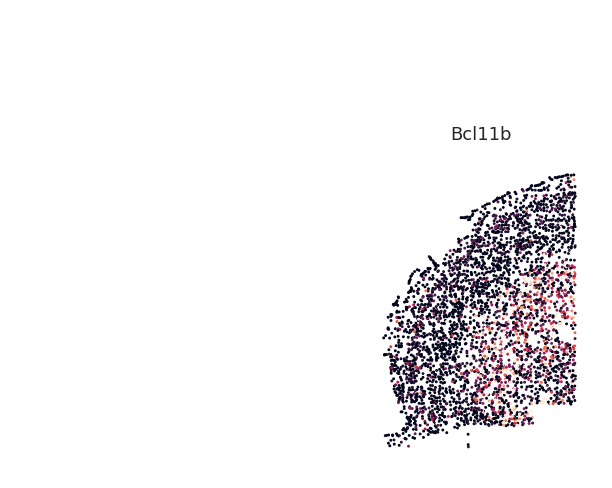

In [14]:
sample_n = 1000
gene = 'Bcl11b'
df_plot = df.join(data_mfish_2.loc[gene].to_frame(gene))

fig, ax = plt.subplots(figsize=(8,6))
tx, ty, tc = 'pos_x (um)', 'pos_y (um)', gene
snmcseq_utils.plot_tsne_values_ax(df_plot[df_plot['sliceID']=='dataset1_slice50'], ax, 
                    tx, ty, tc, 
#                     sample_n=sample_n,
#                     legend_mode=1,
                   )
ax.set_aspect('equal')
ax.grid('off')
plt.show()

In [29]:
# 
it_types = df.loc[df['subclass'].fillna('').str.contains(r'IT'), 'final_label'].unique()
it_types

array(['E8', 'E2', 'E1', 'E9', 'E17', 'E7', 'E16', 'E3', 'E11', 'E5',
       'E13', 'E0', 'E4', 'E10', 'E18', 'E6', 'E12', 'E14', 'E15'], dtype=object)

In [ ]:
joint_cluster = 'cluster_joint_r0.4'

In [37]:
res = (df[['final_label', joint_cluster]].dropna()
                                         .astype({joint_cluster: int})
                                         .groupby(['final_label', joint_cluster])
                                         .size().unstack().fillna(0).astype(int)                                        
      )
res = res.idxmax(axis=1).sort_values()
res

final_label
E9     1
E6     1
E4     1
E14    1
E2     2
E0     2
E12    2
E3     3
E10    3
E13    3
E16    4
E8     4
E7     4
E15    5
E11    5
E17    5
E5     6
E1     6
E18    8
dtype: int64

In [19]:
def filter_type(x):
    if x in it_types:
        return x
    else:
        return "nonIT"
    
def filter_type2(x):
    if x == 'NA':
        return "nonIT" 
    else:
        return str(int(float(x)))
    
    
df_plot = df.copy()
df_plot['final_label'] = df['final_label'].apply(filter_type)
df_plot['cluster_joint_r0.1'] = df['cluster_joint_r0.1'].fillna('NA').astype(str).apply(filter_type2)
df_plot['cluster_joint_r0.4'] = df['cluster_joint_r0.4'].fillna('NA').astype(str).apply(filter_type2)

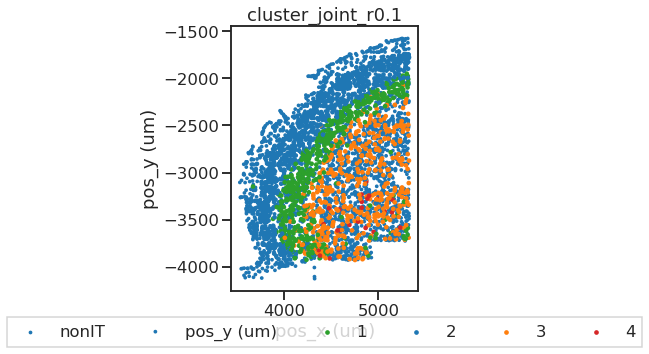

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8*1,6*1))
tx, ty, tc = 'pos_x (um)', 'pos_y (um)', 'cluster_joint_r0.1'
snmcseq_utils.plot_tsne_labels_ax(
    df_plot[((df_plot['sliceID']=='dataset1_slice50') & (df_plot['cluster_joint_r0.1']=='nonIT'))], ax, 
                    tx, ty, tc, 
#                     kw_colors={"nonPT": 'lightgray', '1': 'C2', '2': 'C1', '3': "C0"},
                    legend_mode=1,
                    s=5,
                    t_xlim=None,
                    t_ylim=None,
                    rasterized=True,
                   )
snmcseq_utils.plot_tsne_labels_ax(
    df_plot[((df_plot['sliceID']=='dataset1_slice50') & (df_plot['cluster_joint_r0.1']!='nonIT'))], ax, 
                    tx, ty, tc, 
#                     kw_colors={"nonPT": 'lightgray', '1': 'C2', '2': 'C1', '3': "C0"},
                    legend_mode=1,
                    s=10,
                    t_xlim=None,
                    t_ylim=None,
                    rasterized=True,
                   )
ax.set_aspect('equal')
ax.grid(False)
snmcseq_utils.savefig(fig, figure_format.format('merfish_slice_it.pdf'))
plt.show()

In [23]:
def format_sliceID(x):
    a, b = x[:len('dataset1_slice')], x[len('dataset1_slice'):]
    y = a + b.zfill(3) 
    return y 
format_sliceID('dataset1_slice5')

'dataset1_slice005'

In [43]:
cm_tab20 = plt.get_cmap('tab20').colors
cm_tab20b = plt.get_cmap('tab20b').colors
cm_tab20c = plt.get_cmap('tab20c').colors

In [45]:
[val for key, val in kw_colors.items()]

['lightgray',
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)]

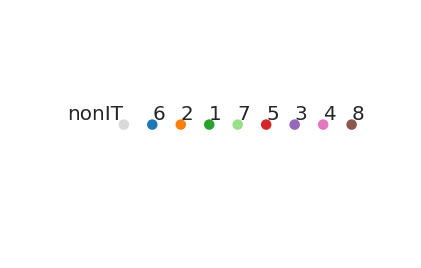

In [66]:
kw_colors=collections.OrderedDict({
                                    "nonIT": cm_tab20c[19], # lightgray
                                    '6': 'C0', # L23
                                    '2': 'C1', # L23
    
                                    '1': 'C2', # L45
                                    '7': cm_tab20[5], # L45 (1)
                                    '5': 'C3', # L45
    
                                    '3': 'C4', # L5
                                    '4': 'C6', # L6
    
                                    '8': 'C5', # L6 Car3
                                  })


scale=0.01
fig, ax = plt.subplots()
ax.scatter(scale*np.arange(len(kw_colors)), [0]*len(kw_colors), c=[val for key, val in kw_colors.items()])
for i, (key, val) in enumerate(kw_colors.items()):
    if i == 0:
        x = -2*scale
    else:
        x = i*scale 
    ax.text(x, 0.001, key, fontsize=20)
ax.axis('off')
snmcseq_utils.savefig(fig, figure_format.format('cluster_legend_it_8clst'))
plt.show()


................................................................

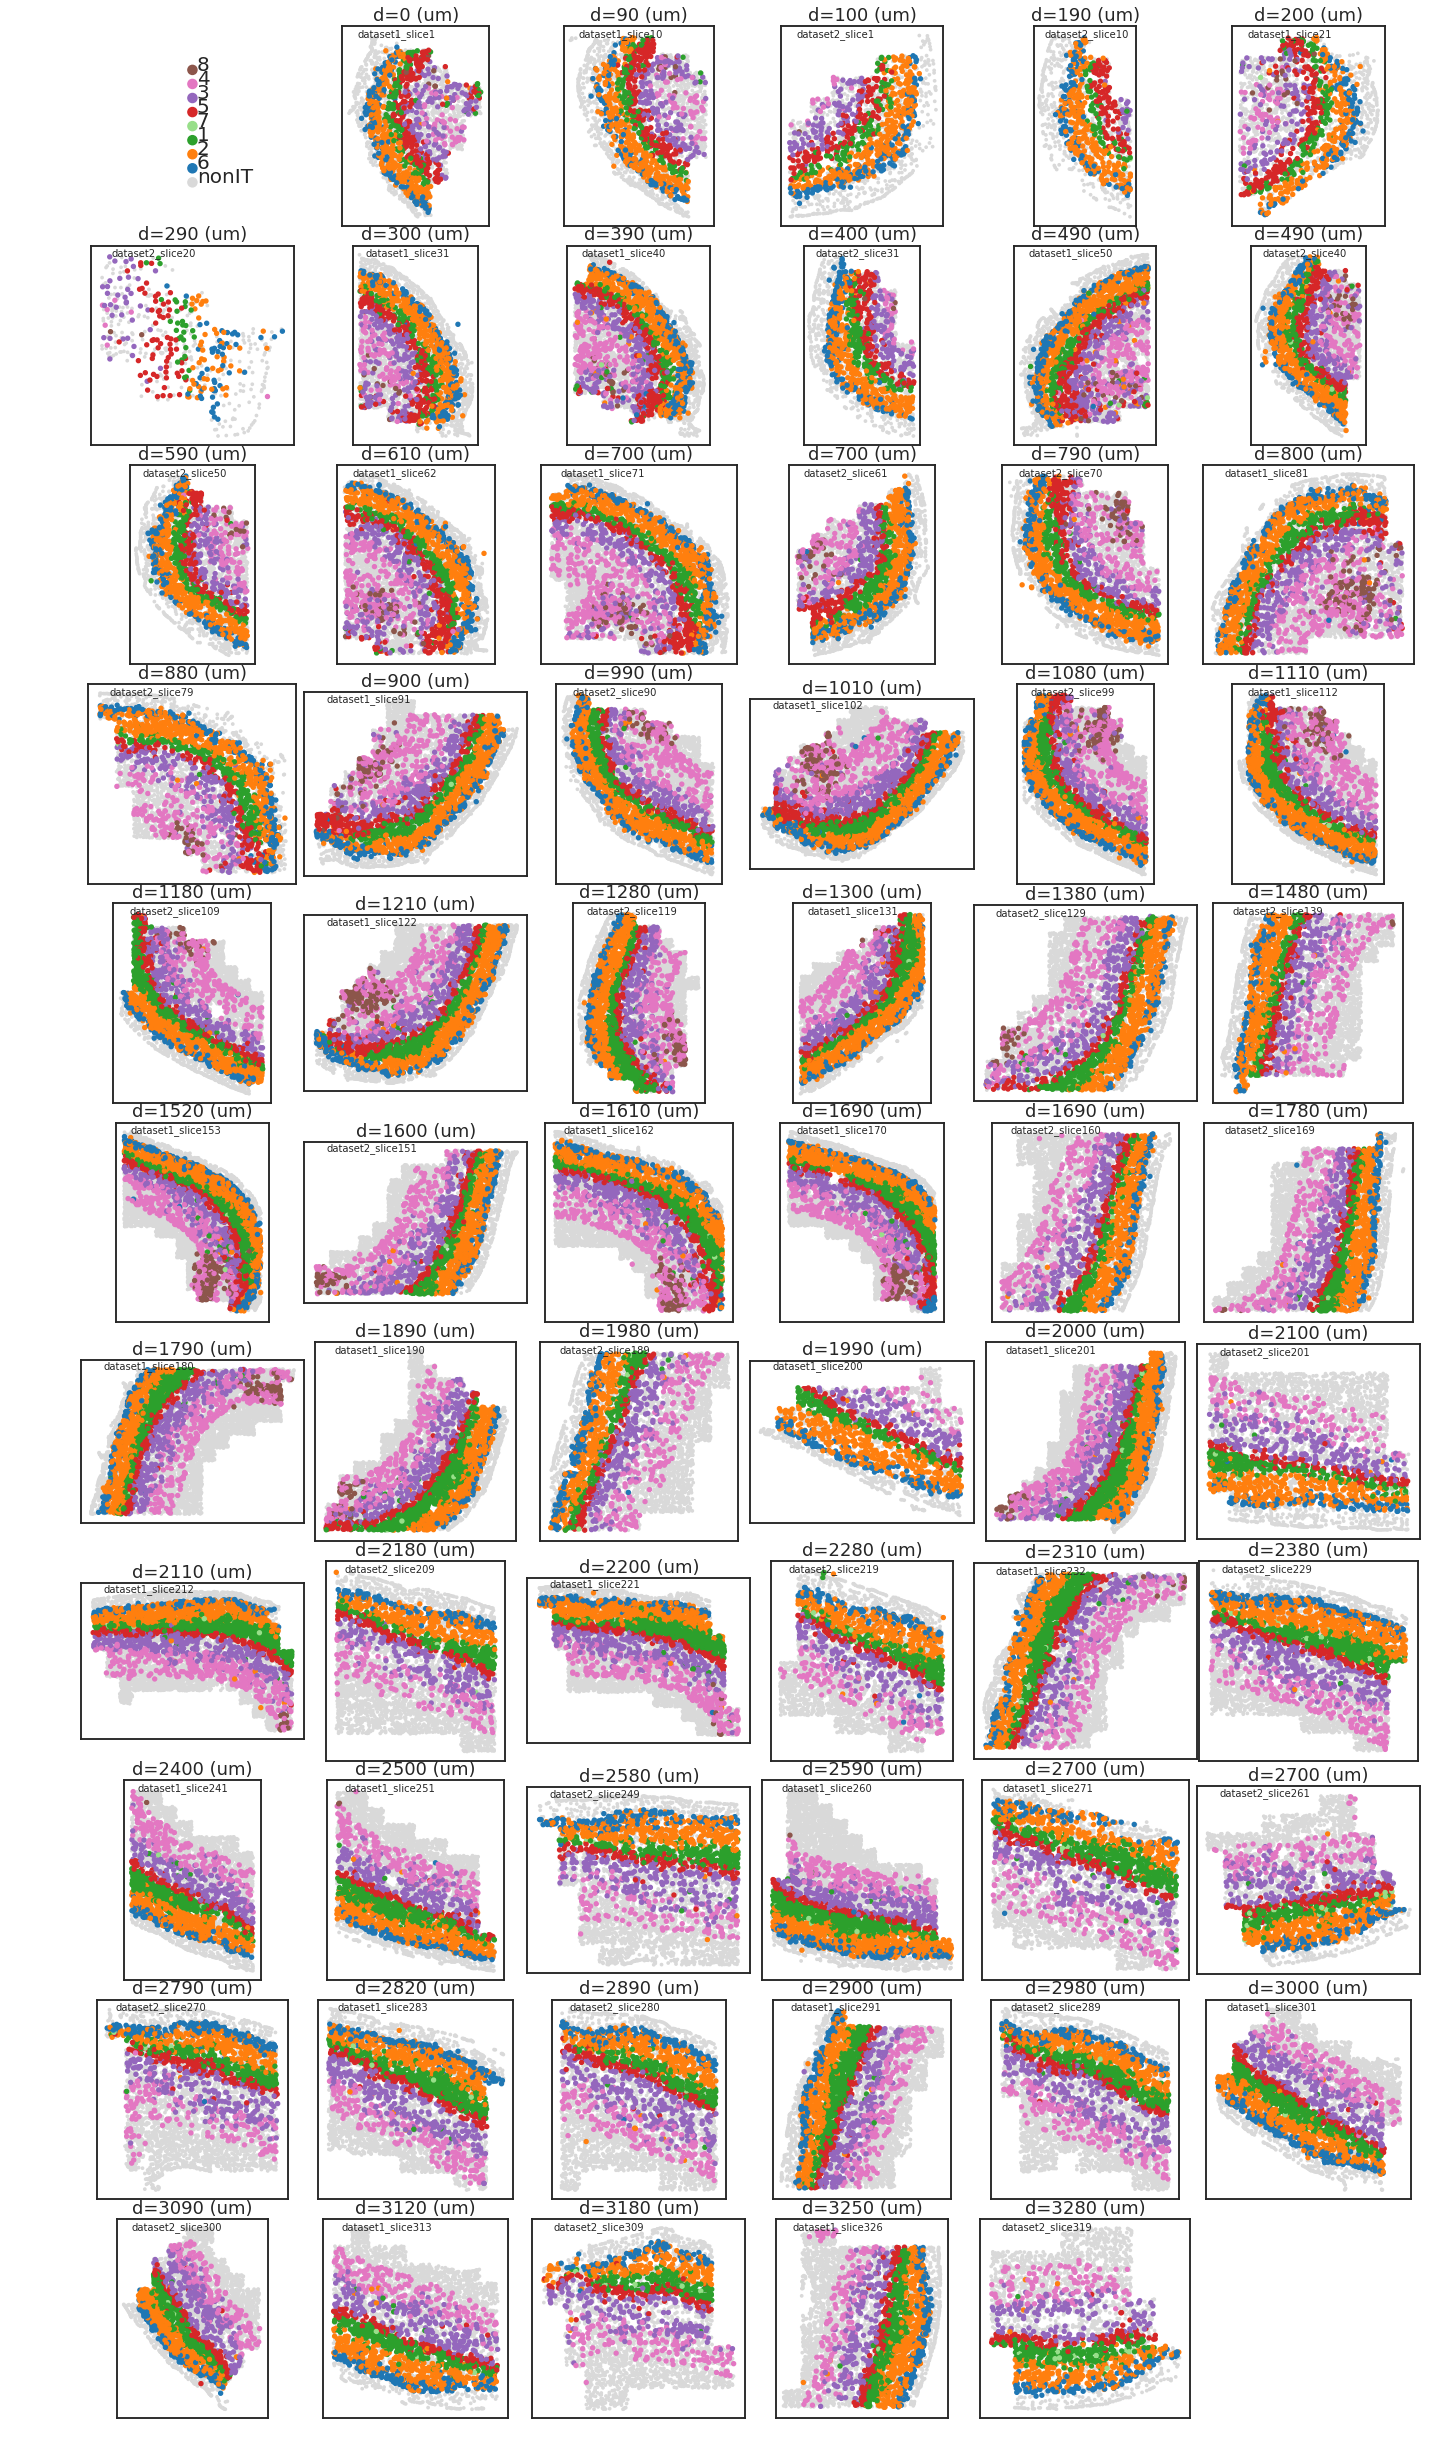

In [56]:
# sample
# n = len(df_plot_sub['sliceID'].unique())

samples = np.sort(df_plot['sampleID'].unique())

n = len(df_plot['sliceID'].unique())+1
nx = 6
ny = int((n+nx-1)/nx) 


tx, ty, tc = 'pos_x (um)', 'pos_y (um)', joint_cluster
fig, axs = plt.subplots(ny, nx, figsize=(4*nx,4*ny))
axs = axs.flatten()

ax = axs[0]
ax.scatter([0]*len(kw_colors), scale*np.arange(len(kw_colors)), c=[val for key, val in kw_colors.items()])
for i, (key, val) in enumerate(kw_colors.items()):
    ax.text(0.001, i*scale, key, fontsize=20)
ax.axis('off')



for i, ((_ap_dis, _slice), df_sub) in enumerate(df_plot.groupby(['AP_distance (um)', 'sliceID'])):
    print('.', end='')
    ax = axs[i+1]
    legend_mode = -1
    legend_kws = {}
    snmcseq_utils.plot_tsne_labels_ax(df_sub[(df_sub[joint_cluster]=='nonIT')], ax, 
                        tx, ty, tc, 
                        kw_colors=kw_colors,
                        legend_mode=-1,
                        s=5,
                        t_xlim=None,
                        t_ylim=None,
                        rasterized=True,
                       )
    snmcseq_utils.plot_tsne_labels_ax(df_sub[(df_sub[joint_cluster]!='nonIT')], ax, 
                        tx, ty, tc, 
                        kw_colors=kw_colors,
                        legend_mode=legend_mode,
                        legend_kws=legend_kws,
                        s=15,
                        t_xlim=None,
                        t_ylim=None,
                        rasterized=True,
                       )
    ax.text(0.1, 0.95, "{}".format(_slice), 
            transform=ax.transAxes,
           )

    ax.set_title("d={} (um)".format(_ap_dis))
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
#     if i == 0:
#         ax.set_ylabel()
#     else:

    ax.set_ylabel('')
    ax.grid(False)

for ax in axs[i+2:]:
    ax.axis('off')

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.1)
snmcseq_utils.savefig(fig, figure_format.format('merfish_slice_it_8clst'))
plt.show()

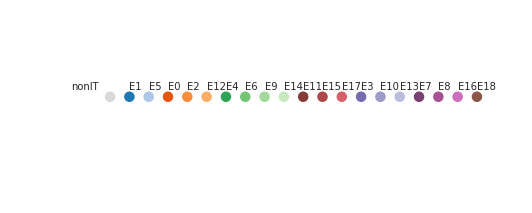

In [71]:
kw_colors=collections.OrderedDict({
                                    "nonIT": cm_tab20c[19], # lightgray
                                    "E1" : cm_tab20[0],# 6
                                    "E5" : cm_tab20[1],# 6
    
                                    "E0" : cm_tab20c[4],# 2
                                    "E2" : cm_tab20c[5],# 2
                                    "E12": cm_tab20c[6],# 2
    
                                    "E4" : cm_tab20c[8],# 1
                                    "E6" : cm_tab20c[9],# 1
                                    "E9" : cm_tab20c[10],# 1
                                    "E14": cm_tab20c[11],# 1
    
                                    "E11": cm_tab20b[12],# 5
                                    "E15": cm_tab20b[13],# 5
                                    "E17": cm_tab20b[14],# 5
    
                                    "E3" : cm_tab20c[12],# 3
                                    "E10": cm_tab20c[13],# 3
                                    "E13": cm_tab20c[14],# 3
    
                                    "E7" : cm_tab20b[16],# 4
                                    "E8" : cm_tab20b[17],# 4
                                    "E16": cm_tab20b[18],# 4
    
                                    "E18": 'C5',# 8
                                  })

scale=0.01
fig, ax = plt.subplots(figsize=(8,3))
ax.scatter(scale*np.arange(len(kw_colors)), [0]*len(kw_colors), c=[val for key, val in kw_colors.items()])
for i, (key, val) in enumerate(kw_colors.items()):
    if i == 0:
        x = -2*scale
    else:
        x = i*scale 
    ax.text(x, 0.003, key, fontsize=10)
ax.axis('off')
snmcseq_utils.savefig(fig, figure_format.format('cluster_legend_it_merfish'))
plt.show()


................................................................

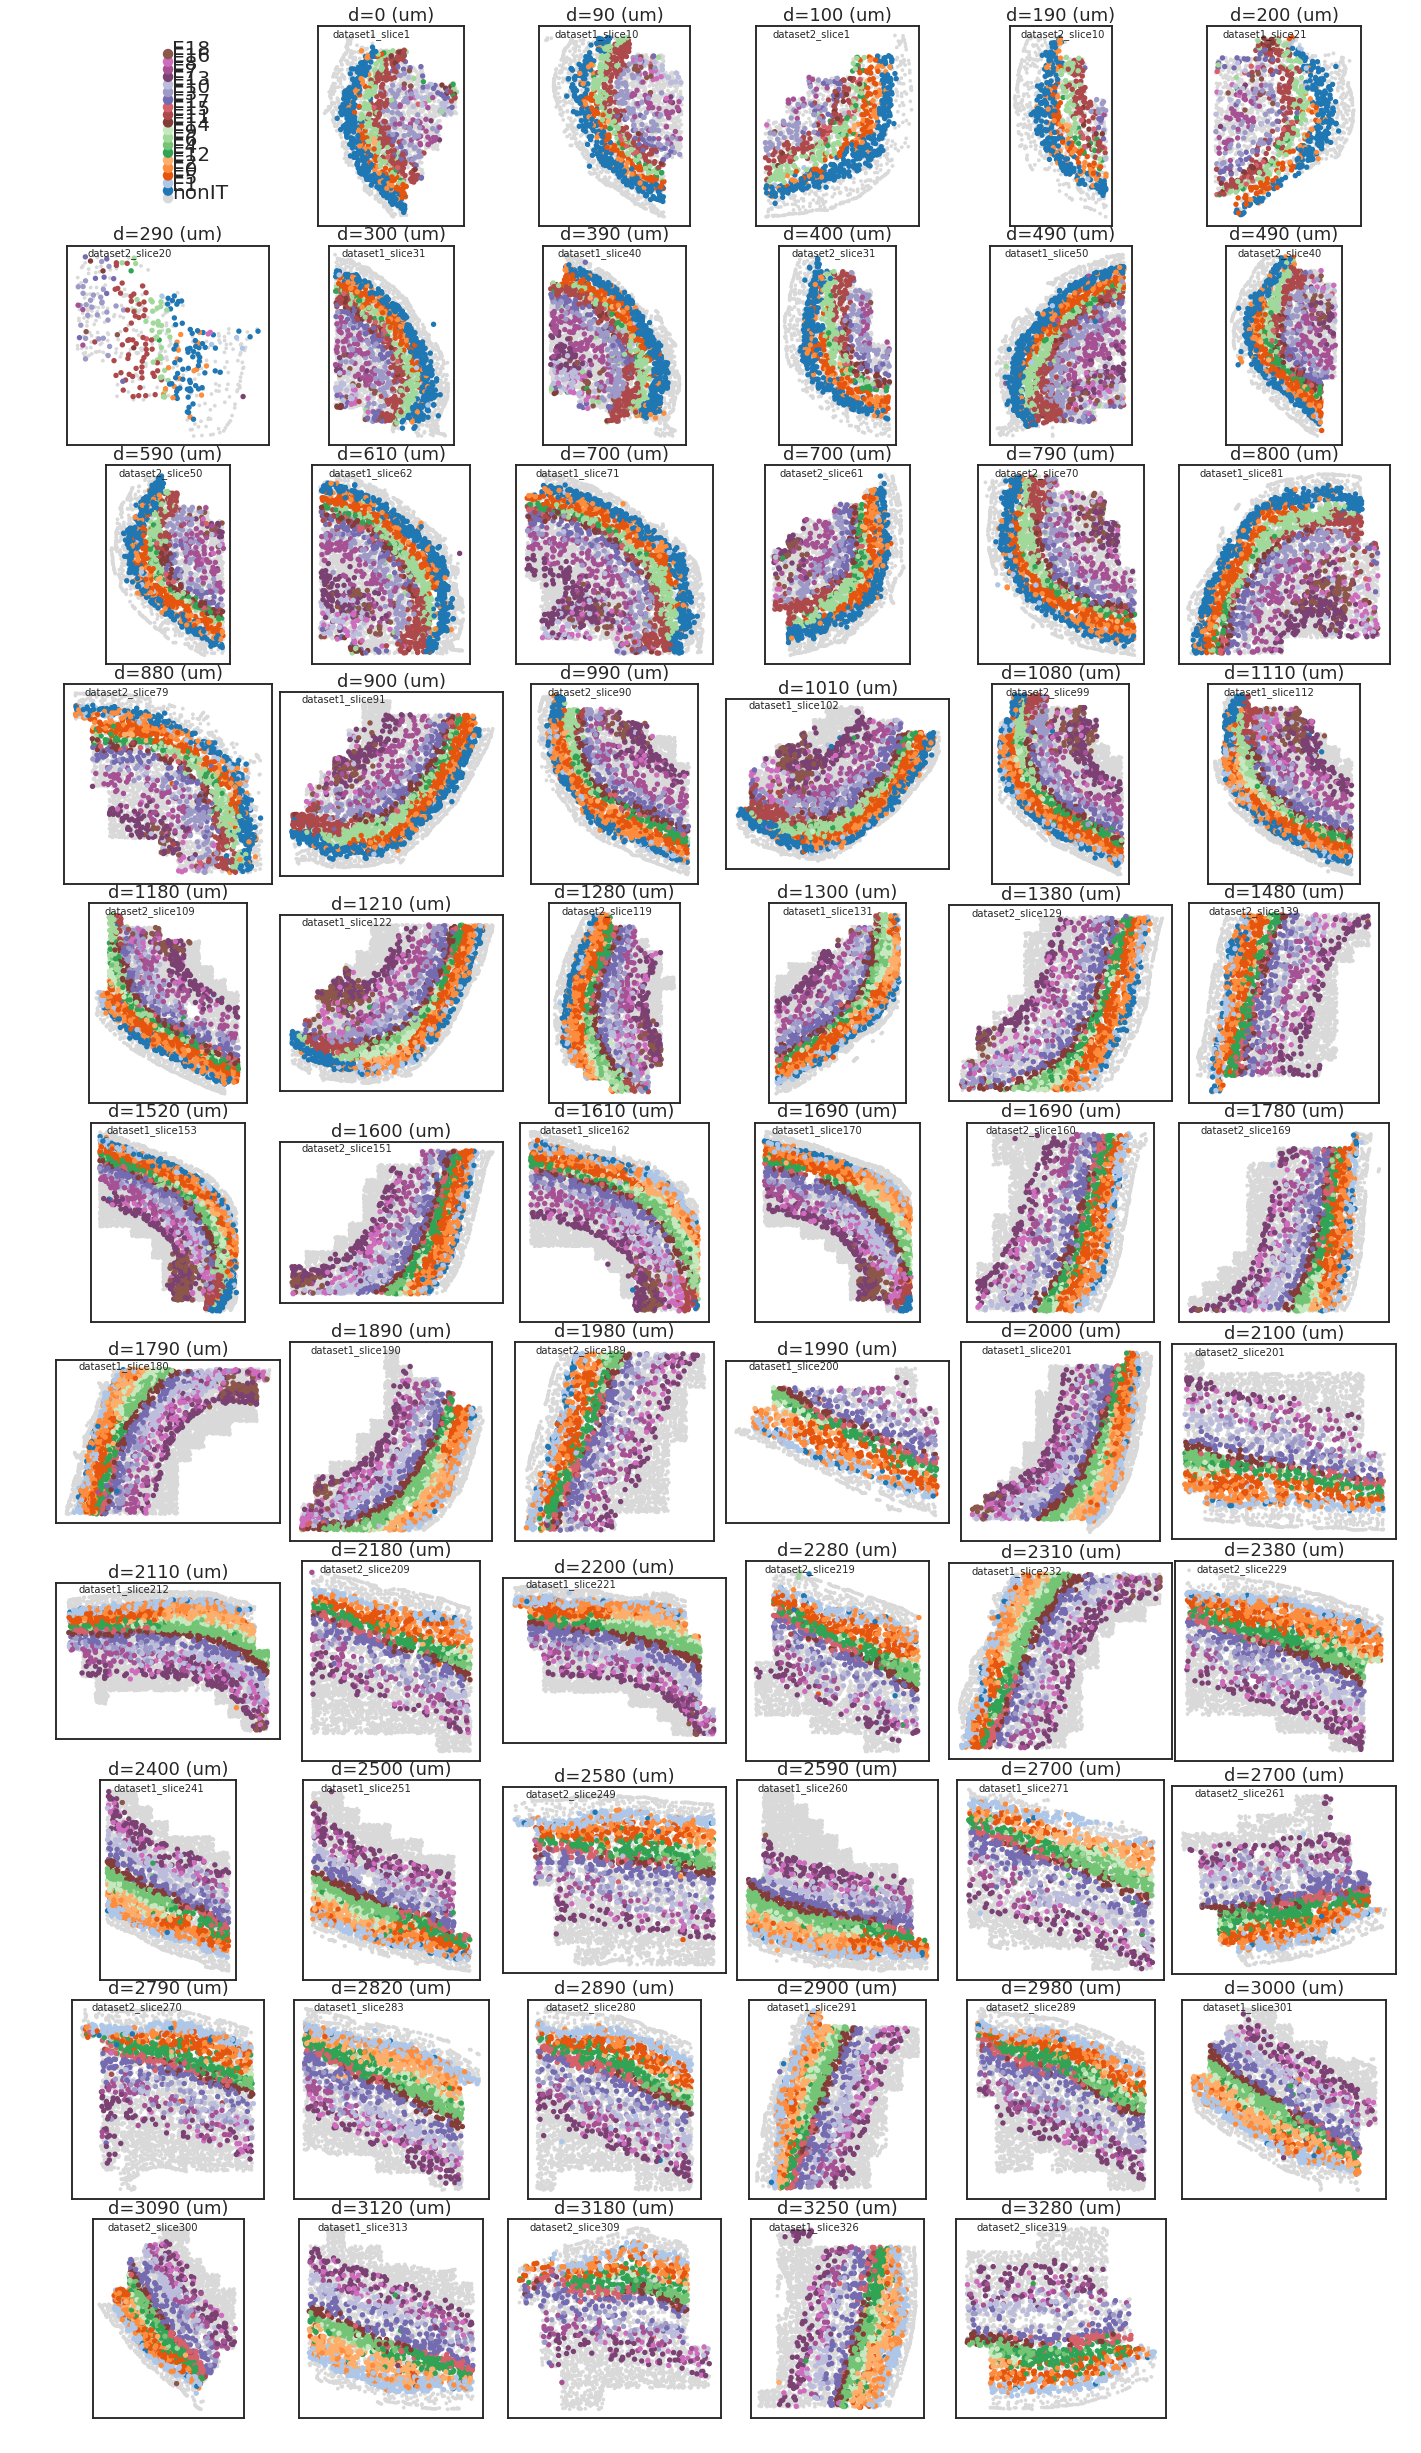

In [59]:
# sample
# n = len(df_plot_sub['sliceID'].unique())

samples = np.sort(df_plot['sampleID'].unique())

n = len(df_plot['sliceID'].unique())+1
nx = 6
ny = int((n+nx-1)/nx) 


tx, ty, tc = 'pos_x (um)', 'pos_y (um)', 'final_label'
fig, axs = plt.subplots(ny, nx, figsize=(4*nx,4*ny))
axs = axs.flatten()

ax = axs[0]
ax.scatter([0]*len(kw_colors), scale*np.arange(len(kw_colors)), c=[val for key, val in kw_colors.items()])
for i, (key, val) in enumerate(kw_colors.items()):
    ax.text(0.001, i*scale, key, fontsize=20)
ax.axis('off')



for i, ((_ap_dis, _slice), df_sub) in enumerate(df_plot.groupby(['AP_distance (um)', 'sliceID'])):
    print('.', end='')
    ax = axs[i+1]
    legend_mode = -1
    legend_kws = {}
    snmcseq_utils.plot_tsne_labels_ax(df_sub[(df_sub[joint_cluster]=='nonIT')], ax, 
                        tx, ty, tc, 
                        kw_colors=kw_colors,
                        legend_mode=-1,
                        s=5,
                        t_xlim=None,
                        t_ylim=None,
                        rasterized=True,
                       )
    snmcseq_utils.plot_tsne_labels_ax(df_sub[(df_sub[joint_cluster]!='nonIT')], ax, 
                        tx, ty, tc, 
                        kw_colors=kw_colors,
                        legend_mode=legend_mode,
                        legend_kws=legend_kws,
                        s=15,
                        t_xlim=None,
                        t_ylim=None,
                        rasterized=True,
                       )
    ax.text(0.1, 0.95, "{}".format(_slice), 
            transform=ax.transAxes,
           )

    ax.set_title("d={} (um)".format(_ap_dis))
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
#     if i == 0:
#         ax.set_ylabel()
#     else:

    ax.set_ylabel('')
    ax.grid(False)

for ax in axs[i+2:]:
    ax.axis('off')

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.1)
snmcseq_utils.savefig(fig, figure_format.format('merfish_slice_it_merfish_cluster'))
plt.show()